<a href="https://colab.research.google.com/github/Alarmelmangai-K/master-thesis/blob/main/Bootstrap_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

--2025-09-20 18:27:39--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383906063 (366M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 366.12M  74.6MB/s    in 5.3s    

2025-09-20 18:27:45 (69.7 MB/s) - ‘variant_summary.txt.gz’ saved [383906063/383906063]



In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a2d3233026e4efac965665e47d3b675f1495b9bff33660a78387c38a1ef4f490
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils import resample
from collections import Counter

In [ ]:
file_path = "variant_summary.txt.gz"
chunksize = 100_000
non_null_counts = None
total_rows = 0
for chunk in pd.read_csv(file_path, sep="\t", chunksize=chunksize, low_memory=False):
    if non_null_counts is None:
        non_null_counts = chunk.notnull().sum()
    else:
        non_null_counts += chunk.notnull().sum()
    total_rows += len(chunk)
fully_populated_columns = [col for col in non_null_counts.index if non_null_counts[col] == total_rows]

print(f"\n with no missing values ({len(fully_populated_columns)} found):")
for col in fully_populated_columns:
    print(f"- {col}")


 with no missing values (43 found):
- #AlleleID
- Type
- Name
- GeneID
- GeneSymbol
- HGNC_ID
- ClinicalSignificance
- ClinSigSimple
- LastEvaluated
- RS# (dbSNP)
- nsv/esv (dbVar)
- RCVaccession
- PhenotypeIDS
- PhenotypeList
- Origin
- OriginSimple
- Assembly
- ChromosomeAccession
- Chromosome
- Start
- Stop
- ReferenceAllele
- AlternateAllele
- Cytogenetic
- ReviewStatus
- NumberSubmitters
- Guidelines
- TestedInGTR
- OtherIDs
- SubmitterCategories
- VariationID
- PositionVCF
- ReferenceAlleleVCF
- AlternateAlleleVCF
- SomaticClinicalImpact
- SomaticClinicalImpactLastEvaluated
- ReviewStatusClinicalImpact
- Oncogenicity
- OncogenicityLastEvaluated
- ReviewStatusOncogenicity
- SCVsForAggregateGermlineClassification
- SCVsForAggregateSomaticClinicalImpact
- SCVsForAggregateOncogenicityClassification


In [ ]:
file_path = "variant_summary.txt.gz"
selected_features = [
    "GeneSymbol", "Type", "ReviewStatus", "Origin", "Chromosome",
    "Cytogenetic", "NumberSubmitters", "PositionVCF",
    "SCVsForAggregateGermlineClassification"
]
target_column = "ClinicalSignificance"
columns_to_load = selected_features + [target_column]
df = pd.read_csv(file_path, sep="\t", usecols=columns_to_load)
major_classes = ["Pathogenic", "Benign"]
df_binary = df[df[target_column].isin(major_classes)].copy()
min_count = df_binary[target_column].value_counts().min()
df_binary_balanced = (
    df_binary.groupby(target_column, group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
).reset_index(drop=True)

print(df_binary_balanced[target_column].value_counts())
X = df_binary_balanced[selected_features].fillna("Unknown")
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
y = LabelEncoder().fit_transform(df_binary_balanced[target_column])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

ClinicalSignificance
Benign        384536
Pathogenic    384536
Name: count, dtype: int64


In [ ]:
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Benign", "Pathogenic"], output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision_Benign": report["Benign"]["precision"],
        "Recall_Benign": report["Benign"]["recall"],
        "F1_Benign": report["Benign"]["f1-score"],
        "Precision_Pathogenic": report["Pathogenic"]["precision"],
        "Recall_Pathogenic": report["Pathogenic"]["recall"],
        "F1_Pathogenic": report["Pathogenic"]["f1-score"],
        "Predictions": y_pred  # Add predictions here
    })
results_df = pd.DataFrame(results)
print("\n Model Performance Summary:")
print(results_df.sort_values(by="Accuracy", ascending=False).to_string(index=False))


 Model Performance Summary:
           Model  Accuracy  Precision_Benign  Recall_Benign  F1_Benign  Precision_Pathogenic  Recall_Pathogenic  F1_Pathogenic                                                                                                                                                                                                                                                                                                       Predictions
    DecisionTree  0.980067          0.980130       0.980002   0.980066              0.980004           0.980132       0.980068 [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, ...]
    RandomForest  0.979761          0.987205       0.972123   0.979606              0.972542           0.

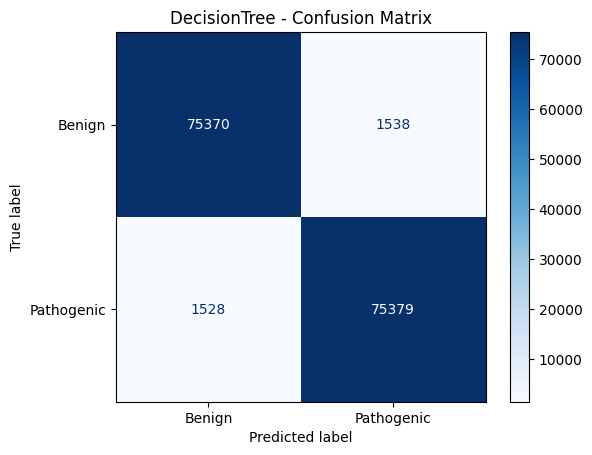

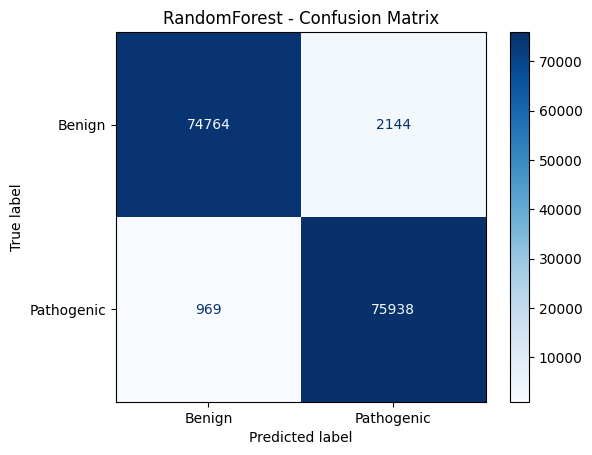

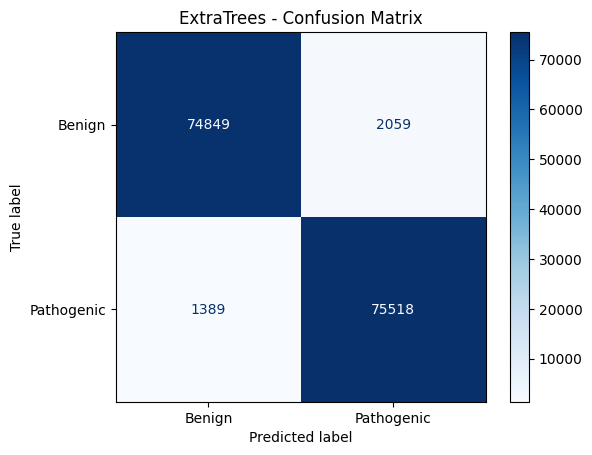

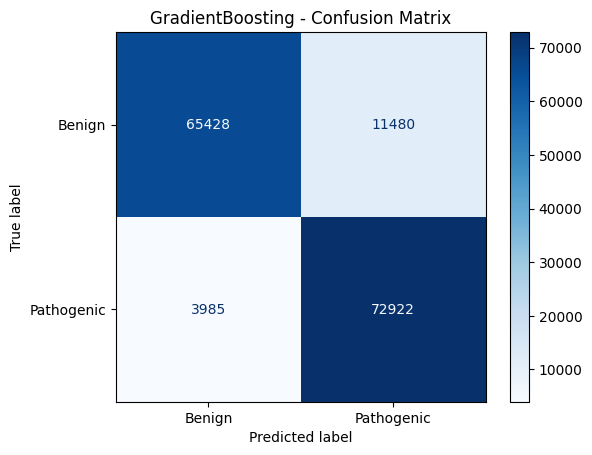

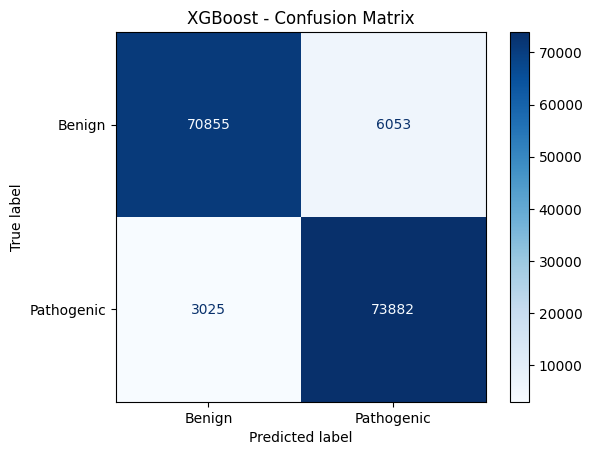

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for result in results:
    model_name = result["Model"]
    y_pred = result["Predictions"]
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Pathogenic"])
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

In [ ]:
subset_indices = np.random.choice(len(X_test), size=500, replace=False)
X_subset = X_test.iloc[subset_indices]
y_subset = y_test[subset_indices]

In [ ]:
feature_names = X_subset.columns.tolist()
perm_dict = {}
for name, model in models.items():
    result = permutation_importance(model, X_subset, y_subset, n_repeats=10, random_state=42)
    perm_dict[name] = dict(zip(feature_names, result.importances_mean))
print("\n Permutation Importance:")
print(pd.DataFrame(perm_dict).T)


 Permutation Importance:
                  GeneSymbol    Type  ReviewStatus  Origin  Chromosome  \
DecisionTree          0.0460  0.0648        0.0918  0.0708      0.0184   
RandomForest          0.0436  0.0614        0.1108  0.0938      0.0112   
ExtraTrees            0.0624  0.0956        0.1222  0.1140      0.0270   
GradientBoosting      0.0062  0.0242        0.0180  0.0328      0.0000   
XGBoost               0.0190  0.0250        0.0636  0.0590     -0.0004   

                  Cytogenetic  NumberSubmitters  PositionVCF  \
DecisionTree           0.0438            0.0152       0.0320   
RandomForest           0.0326            0.0274       0.0382   
ExtraTrees             0.0366            0.0452       0.0404   
GradientBoosting       0.0056            0.0000       0.0000   
XGBoost                0.0040            0.0078       0.0048   

                  SCVsForAggregateGermlineClassification  
DecisionTree                                      0.4040  
RandomForest              

In [ ]:
shap_dict = {}
for name, model in models.items():
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_subset)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    mean_abs = np.abs(shap_values).mean(axis=0)
    shap_dict[name] = dict(zip(feature_names, mean_abs))
print("\n SHAP Values:")
print(pd.DataFrame(shap_dict).T)


 SHAP Values:
                                                   GeneSymbol  \
DecisionTree      [0.01813564555132348, 0.018135645551323472]   
RandomForest      [0.02044803428506304, 0.020448034285062654]   
ExtraTrees         [0.02702970949590375, 0.02702970949589947]   
GradientBoosting                                     0.039099   
XGBoost                                              0.257238   

                                                        Type  \
DecisionTree      [0.13014395570427315, 0.13014395570427362]   
RandomForest       [0.11959952078540603, 0.1195995207854085]   
ExtraTrees         [0.1353022089516629, 0.13530220895165637]   
GradientBoosting                                    0.776401   
XGBoost                                             0.897391   

                                                 ReviewStatus  \
DecisionTree       [0.04441727989647124, 0.04441727989647109]   
RandomForest        [0.05528021830467198, 0.0552802183046736]   
ExtraTrees    

In [ ]:
explainer = LimeTabularExplainer(
    training_data=X_subset.values,
    feature_names=feature_names,
    class_names=["Benign", "Pathogenic"],
    discretize_continuous=False
)
lime_dict = {}
for name, model in models.items():
    lime_scores = np.zeros(len(feature_names))
    for i in range(50):
        instance = X_subset.iloc[i:i+1]
        exp = explainer.explain_instance(
            data_row=instance.values[0],
            predict_fn=model.predict_proba,
            num_features=len(feature_names)
        )
        for feat, score in exp.as_list():
            if feat in feature_names:
                idx = feature_names.index(feat)
                lime_scores[idx] += abs(score)
    lime_dict[name] = dict(zip(feature_names, lime_scores / 50))
print("\n LIME Scores:")
print(pd.DataFrame(lime_dict).T)


 LIME Scores:
                  GeneSymbol      Type  ReviewStatus    Origin  Chromosome  \
DecisionTree        0.005654  0.034508      0.030060  0.016367    0.007567   
RandomForest        0.010469  0.009050      0.018637  0.024308    0.005792   
ExtraTrees          0.003900  0.007739      0.039544  0.011226    0.008983   
GradientBoosting    0.019405  0.025283      0.060938  0.061999    0.004193   
XGBoost             0.023797  0.024764      0.022150  0.098653    0.005758   

                  Cytogenetic  NumberSubmitters  PositionVCF  \
DecisionTree         0.008991          0.021511     0.019067   
RandomForest         0.007466          0.014520     0.006568   
ExtraTrees           0.001856          0.006775     0.005751   
GradientBoosting     0.004093          0.004274     0.003674   
XGBoost              0.010399          0.004312     0.005448   

                  SCVsForAggregateGermlineClassification  
DecisionTree                                    0.021217  
RandomForest 

In [ ]:
feature_importance_dict = {}
for name, model in models.items():
    importances = model.feature_importances_
    feature_importance_dict[name] = dict(zip(feature_names, importances))
feature_importance_df = pd.DataFrame(feature_importance_dict).T
print(" Built-in Feature Importances:")
print(feature_importance_df)

 Built-in Feature Importances:
                  GeneSymbol      Type  ReviewStatus    Origin  Chromosome  \
DecisionTree        0.047524  0.205411      0.095705  0.064819    0.009571   
RandomForest        0.065697  0.168073      0.083874  0.070952    0.019071   
ExtraTrees          0.082252  0.186361      0.080137  0.076884    0.032649   
GradientBoosting    0.009641  0.291357      0.088655  0.067368    0.000073   
XGBoost             0.021887  0.382088      0.183287  0.150418    0.012767   

                  Cytogenetic  NumberSubmitters  PositionVCF  \
DecisionTree         0.030540          0.011895     0.034194   
RandomForest         0.046032          0.023307     0.073066   
ExtraTrees           0.060816          0.028298     0.088640   
GradientBoosting     0.000721          0.000129     0.001004   
XGBoost              0.015843          0.015331     0.017337   

                  SCVsForAggregateGermlineClassification  
DecisionTree                                    0.500342

Bootstrap FSI

This code's primary goal is to determine which features are consistently ranked as important by your models. It trains the models on different data samples and collects the feature_importances_ scores. The final FSI score tells you which features the model consistently relies on, regardless of minor variations in the training data.

In [ ]:
feature_names = X_subset.columns.tolist()
fsi_matrix = {name: {feat: [] for feat in feature_names} for name in models.keys()}
for b in range(10):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + b)
    for name, model in models.items():
        model.fit(X_boot, y_boot)
        if hasattr(model, "feature_importances_"):
            for feat, score in zip(feature_names, model.feature_importances_):
                fsi_matrix[name][feat].append(score)
fsi_scores = {}
for name in fsi_matrix:
    fsi_scores[name] = {
        feat: np.mean(fsi_matrix[name][feat]) / (np.std(fsi_matrix[name][feat]) + 1e-6)
        for feat in feature_names
    }
fsi_df = pd.DataFrame(fsi_scores)
print(fsi_df.to_string())

                                        DecisionTree  RandomForest  ExtraTrees  GradientBoosting    XGBoost
GeneSymbol                                 36.764443    118.806983  165.088280         11.338507  19.555012
Type                                      259.946312    162.500889  115.225193        105.428341  32.750919
ReviewStatus                              111.335446     39.242074   66.065509         34.106193  35.108665
Origin                                     33.666847     63.434662   70.056023         17.823094  25.271580
Chromosome                                 25.435164     62.505585   75.675007          2.116554   9.764701
Cytogenetic                                50.420951    151.395543  129.886639          4.885654  24.316334
NumberSubmitters                           18.597490     29.322592   25.493838          2.359434  18.619854
PositionVCF                                29.256605     72.886027  101.592901          2.668490  16.965120
SCVsForAggregateGermlineClas

In [ ]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42
)

# -------------------------------
# Bootstrap function (predict on validation set!)
# -------------------------------
def bootstrap_metric(model, X_train, y_train, X_val, y_val, metric=accuracy_score, B=20, ci_level=95):
    metrics = []
    n = len(y_train)
    for _ in range(B):
        # Bootstrap sample from training set
        X_res, y_res = resample(X_train, y_train, n_samples=n, random_state=None)

        # Clone the model so we start fresh
        model_clone = clone(model)
        model_clone.fit(X_res, y_res)

        # Predict on the separate validation set
        y_pred = model_clone.predict(X_val)
        metrics.append(metric(y_val, y_pred))

    metrics = np.array(metrics)
    mean = metrics.mean()
    lower = np.percentile(metrics, (100 - ci_level)/2)
    upper = np.percentile(metrics, 100 - (100 - ci_level)/2)
    return mean, lower, upper

# -------------------------------
# Compute bootstrap accuracy + CI for all models
# -------------------------------
accuracy_CI = {}
for name, model in models.items():
    mean_acc, lower, upper = bootstrap_metric(
        model, X_train_sub, y_train_sub, X_val_sub, y_val_sub, B=20
    )
    accuracy_CI[name] = (mean_acc, lower, upper)

# -------------------------------
# Print results
# -------------------------------
print("Bootstrap Accuracy with 95% CI:")
for name, (mean, l, u) in accuracy_CI.items():
    print(f"{name}: Accuracy = {mean:.4f} ({l:.4f} - {u:.4f})")

Bootstrap Accuracy with 95% CI:
DecisionTree: Accuracy = 0.7185 (0.6195 - 0.7953)
RandomForest: Accuracy = 0.7240 (0.6748 - 0.7705)
ExtraTrees: Accuracy = 0.7075 (0.6495 - 0.7510)
GradientBoosting: Accuracy = 0.8125 (0.7342 - 0.8652)
XGBoost: Accuracy = 0.7800 (0.7242 - 0.8252)


**Model Performance Stability**
This is the second code block you shared, which uses bootstrapping to evaluate the overall performance metrics of your models.

This code's purpose is to evaluate the stability of the model's overall performance. It trains the models on different data samples but always evaluates them on a fixed test set. The output—the mean and standard deviation of accuracy, precision, recall, and F1-score—tells you how much the model's performance fluctuates when trained on slightly different datasets. A low standard deviation indicates a more robust and reliable model.

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

boot_metrics = {name: [] for name in models}

for b in range(10):  # 10 bootstraps
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + b)
    X_val, y_val = X_test, y_test

    for name, model in models.items():
        model.fit(X_boot, y_boot)
        y_pred = model.predict(X_val)

        boot_metrics[name].append({
            "accuracy": accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred),
            "recall": recall_score(y_val, y_pred),
            "f1": f1_score(y_val, y_pred)
        })
summary = []
for name in boot_metrics:
    accs = [m["accuracy"] for m in boot_metrics[name]]
    precs = [m["precision"] for m in boot_metrics[name]]
    recalls = [m["recall"] for m in boot_metrics[name]]
    f1s = [m["f1"] for m in boot_metrics[name]]
    summary.append({
        "Model": name,
        "Accuracy": f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
        "Precision": f"{np.mean(precs):.3f} ± {np.std(precs):.3f}",
        "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
        "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    })
df_summary = pd.DataFrame(summary)
print(df_summary)

              Model       Accuracy      Precision         Recall  \
0      DecisionTree  0.964 ± 0.000  0.964 ± 0.001  0.963 ± 0.001   
1      RandomForest  0.969 ± 0.000  0.961 ± 0.000  0.979 ± 0.000   
2        ExtraTrees  0.962 ± 0.001  0.957 ± 0.001  0.968 ± 0.001   
3  GradientBoosting  0.898 ± 0.002  0.862 ± 0.004  0.948 ± 0.003   
4           XGBoost  0.941 ± 0.001  0.924 ± 0.001  0.961 ± 0.001   

              F1  
0  0.964 ± 0.000  
1  0.970 ± 0.000  
2  0.962 ± 0.001  
3  0.903 ± 0.002  
4  0.942 ± 0.001  


This output is a summary of the consensus among different feature importance methods, specifically identifying which features are most frequently considered important by your models.

In [ ]:
def top_features(importance_dict, top_n=5):
    top_dict = {}
    for model, scores in importance_dict.items():
        cleaned_scores = []
        for feature, score in scores.items():
            if hasattr(score, '__len__') and not isinstance(score, str):
                cleaned_scores.append((feature, float(np.mean(score))))
            else:
                cleaned_scores.append((feature, float(score)))
        top_dict[model] = sorted(cleaned_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return top_dict

In [ ]:
top_shap = top_features(shap_dict)
top_lime = top_features(lime_dict)
top_perm = top_features(perm_dict)
top_builtin = top_features(feature_importance_dict)
def feature_overlap(*top_dicts):
    all_features = []
    for d in top_dicts:
        for model in d:
            all_features.extend([f[0] for f in d[model]])
    return Counter(all_features)

In [ ]:
overlap = feature_overlap(top_shap, top_lime, top_perm, top_builtin)
overlap_df = pd.DataFrame(overlap.items(), columns=["Feature", "Frequency"])
overlap_df = overlap_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)
print(overlap_df)

                                  Feature  Frequency
0  SCVsForAggregateGermlineClassification         20
1                            ReviewStatus         20
2                                    Type         19
3                                  Origin         18
4                              GeneSymbol         15
5                             PositionVCF          4
6                        NumberSubmitters          2
7                             Cytogenetic          1
8                              Chromosome          1


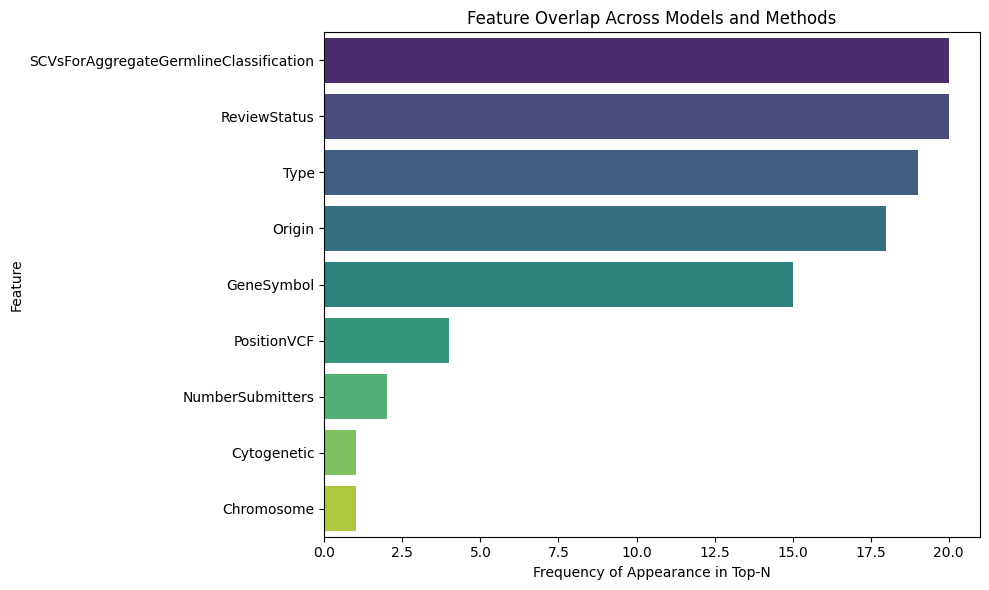

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=overlap_df, x="Frequency", y="Feature", palette="viridis")
plt.title("Feature Overlap Across Models and Methods")
plt.xlabel("Frequency of Appearance in Top-N")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Pearson correlation between columns, i.e., between models.
Each value tells you how similar the feature importance rankings are between two models.

In [ ]:
importance_df = pd.DataFrame({
    model: pd.Series(scores) for model, scores in feature_importance_dict.items()
}).fillna(0)
correlation_matrix = importance_df.corr()
print(correlation_matrix)

                  DecisionTree  RandomForest  ExtraTrees  GradientBoosting  \
DecisionTree          1.000000      0.994173    0.988400          0.987109   
RandomForest          0.994173      1.000000    0.991347          0.968038   
ExtraTrees            0.988400      0.991347    1.000000          0.975139   
GradientBoosting      0.987109      0.968038    0.975139          1.000000   
XGBoost               0.599944      0.531643    0.595840          0.704128   

                   XGBoost  
DecisionTree      0.599944  
RandomForest      0.531643  
ExtraTrees        0.595840  
GradientBoosting  0.704128  
XGBoost           1.000000  


Spearman correlation between all bootstrap pairs → mean = FSI, percentiles = CI.

In [ ]:
from scipy.stats import spearmanr

stability_CI = {}
# During bootstrap importance calculation
all_importances = {name: [] for name in models}

for name, model in models.items():
    for _ in range(B):
        X_res, y_res = resample(X_subset, y_subset, n_samples=len(y_train))
        model_clone = clone(model)
        model_clone.fit(X_res, y_res)
        if hasattr(model_clone, "feature_importances_"):
            imp = model_clone.feature_importances_
        else:
            perm = permutation_importance(model_clone, X_res, y_res, n_repeats=5, random_state=None)
            imp = perm.importances_mean
        all_importances[name].append(imp)

# Convert to numpy arrays
for name in all_importances:
    all_importances[name] = np.array(all_importances[name])  # shape B x n_features
for name, importances_matrix in all_importances.items():
    mean_fsi, lower_fsi, upper_fsi = compute_FSI(importances_matrix)
    stability_CI[name] = (mean_fsi, lower_fsi, upper_fsi)



In [ ]:
# Example print
for name, (mean, l, u) in stability_CI.items():
    print(f"{name}: FSI = {mean:.4f} ({l:.4f}-{u:.4f})")

DecisionTree: FSI = 0.9619 (0.8700-1.0000)
RandomForest: FSI = 1.0000 (1.0000-1.0000)
ExtraTrees: FSI = 1.0000 (1.0000-1.0000)
GradientBoosting: FSI = 0.9652 (0.9167-1.0000)
XGBoost: FSI = 0.8904 (0.7033-0.9833)


bootstraping on SHAP

In [ ]:
top_features = [
    'SCVsForAggregateGermlineClassification',
    'ReviewStatus',
    'Type',
    'Origin',
    'GeneSymbol'
]
X_train_top5 = X_train[top_features]
shap_matrix_top5 = {
    model_name: {feature: [] for feature in top_features}
    for model_name in models
}
for bootstrap_index in range(10):
    X_sample, y_sample = resample(
        X_train_top5, y_train,
        n_samples=100,
        random_state=bootstrap_index
    )
    for model_name, model in models.items():
        model.fit(X_sample, y_sample)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        mean_shap = np.abs(shap_values).mean(axis=0)
        for feature, score in zip(top_features, mean_shap):
            shap_matrix_top5[model_name][feature].append(score)
shap_stability_scores = {
    model_name: {
        feature: np.mean(shap_matrix_top5[model_name][feature]) /
                 (np.std(shap_matrix_top5[model_name][feature]) + 1e-6)
        for feature in top_features
    }
    for model_name in models
}
shap_summary = []
for model_name, feature_scores in shap_stability_scores.items():
    for feature, stability in feature_scores.items():
        shap_summary.append({
            'Model': model_name,
            'Feature': feature,
            'Stability': round(stability, 4)
        })

shap_df_top5 = pd.DataFrame(shap_summary)
print(shap_df_top5.sort_values(by='Stability', ascending=False))

               Model                                 Feature  Stability
24           XGBoost                              GeneSymbol     6.2014
9       RandomForest                              GeneSymbol     5.6353
14        ExtraTrees                              GeneSymbol     5.6029
20           XGBoost  SCVsForAggregateGermlineClassification     5.5310
10        ExtraTrees  SCVsForAggregateGermlineClassification     4.4359
5       RandomForest  SCVsForAggregateGermlineClassification     3.9854
19  GradientBoosting                              GeneSymbol     3.5383
12        ExtraTrees                                    Type     3.4570
0       DecisionTree  SCVsForAggregateGermlineClassification     3.3913
11        ExtraTrees                            ReviewStatus     3.2662
4       DecisionTree                              GeneSymbol     3.1234
15  GradientBoosting  SCVsForAggregateGermlineClassification     3.0828
7       RandomForest                                    Type    

In [ ]:
import shap
from sklearn.utils import resample
import numpy as np

# Define top 5 features
top_features = [
    'SCVsForAggregateGermlineClassification',
    'ReviewStatus',
    'Type',
    'Origin',
    'GeneSymbol'
]

# Filter training data to top 5 features
X_train_top5 = X_train[top_features]

# Initialize SHAP storage
shap_matrix_top5 = {
    model_name: {feature: [] for feature in top_features}
    for model_name in models
}

# Perform 10 bootstraps with 100 samples each
for bootstrap_index in range(10):
    X_sample, y_sample = resample(
        X_train_top5, y_train,
        n_samples=500,
        random_state=bootstrap_index
    )

    for model_name, model in models.items():
        model.fit(X_sample, y_sample)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)

        # Handle binary classification
        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        mean_shap = np.abs(shap_values).mean(axis=0)

        for feature, score in zip(top_features, mean_shap):
            shap_matrix_top5[model_name][feature].append(score)

# Compute SHAP stability scores
shap_stability_scores = {
    model_name: {
        feature: np.mean(shap_matrix_top5[model_name][feature]) /
                 (np.std(shap_matrix_top5[model_name][feature]) + 1e-6)
        for feature in top_features
    }
    for model_name in models
}

# Convert to DataFrame for display
import pandas as pd

shap_summary = []
for model_name, feature_scores in shap_stability_scores.items():
    for feature, stability in feature_scores.items():
        shap_summary.append({
            'Model': model_name,
            'Feature': feature,
            'Stability': round(stability, 4)
        })

shap_df_top5 = pd.DataFrame(shap_summary)
print(shap_df_top5.sort_values(by='Stability', ascending=False))

               Model                                 Feature  Stability
14        ExtraTrees                              GeneSymbol    14.8158
10        ExtraTrees  SCVsForAggregateGermlineClassification    13.9404
2       DecisionTree                                    Type    13.8377
11        ExtraTrees                            ReviewStatus    13.7533
20           XGBoost  SCVsForAggregateGermlineClassification    13.7367
24           XGBoost                              GeneSymbol    11.5315
5       RandomForest  SCVsForAggregateGermlineClassification    11.0922
7       RandomForest                                    Type    10.9733
12        ExtraTrees                                    Type    10.9640
22           XGBoost                                    Type    10.3368
9       RandomForest                              GeneSymbol     9.2698
17  GradientBoosting                                    Type     8.4999
6       RandomForest                            ReviewStatus    

In [ ]:
import shap
from sklearn.utils import resample
import numpy as np

# Define top 5 features
top_features = [
    'SCVsForAggregateGermlineClassification',
    'ReviewStatus',
    'Type',
    'Origin',
    'GeneSymbol'
]

# Filter training data to top 5 features
X_train_top5 = X_train[top_features]

# Initialize SHAP storage
shap_matrix_top5 = {
    model_name: {feature: [] for feature in top_features}
    for model_name in models
}

# Perform 10 bootstraps with 100 samples each
for bootstrap_index in range(10):
    X_sample, y_sample = resample(
        X_train_top5, y_train,
        n_samples=1000,
        random_state=bootstrap_index
    )

    for model_name, model in models.items():
        model.fit(X_sample, y_sample)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)

        # Handle binary classification
        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        mean_shap = np.abs(shap_values).mean(axis=0)

        for feature, score in zip(top_features, mean_shap):
            shap_matrix_top5[model_name][feature].append(score)

# Compute SHAP stability scores
shap_stability_scores = {
    model_name: {
        feature: np.mean(shap_matrix_top5[model_name][feature]) /
                 (np.std(shap_matrix_top5[model_name][feature]) + 1e-6)
        for feature in top_features
    }
    for model_name in models
}

# Convert to DataFrame for display
import pandas as pd

shap_summary = []
for model_name, feature_scores in shap_stability_scores.items():
    for feature, stability in feature_scores.items():
        shap_summary.append({
            'Model': model_name,
            'Feature': feature,
            'Stability': round(stability, 4)
        })

shap_df_top5 = pd.DataFrame(shap_summary)
print(shap_df_top5.sort_values(by='Stability', ascending=False))

               Model                                 Feature  Stability
2       DecisionTree                                    Type    20.7930
14        ExtraTrees                              GeneSymbol    19.3380
10        ExtraTrees  SCVsForAggregateGermlineClassification    18.1003
20           XGBoost  SCVsForAggregateGermlineClassification    15.3635
5       RandomForest  SCVsForAggregateGermlineClassification    15.1686
0       DecisionTree  SCVsForAggregateGermlineClassification    14.3333
24           XGBoost                              GeneSymbol    13.8055
6       RandomForest                            ReviewStatus    13.2115
7       RandomForest                                    Type    12.6179
11        ExtraTrees                            ReviewStatus    12.3040
12        ExtraTrees                                    Type    12.2165
9       RandomForest                              GeneSymbol    11.8686
15  GradientBoosting  SCVsForAggregateGermlineClassification    

bootstraping on permutation importance

In [ ]:
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# Use only top 5 features
top_features = [
    'SCVsForAggregateGermlineClassification',
    'ReviewStatus',
    'Type',
    'Origin',
    'GeneSymbol'
]

X_train_top5 = X_train[top_features]

# Initialize storage
perm_matrix = {
    model_name: {feature: [] for feature in top_features}
    for model_name in models
}

# Bootstrapping loop (e.g., 10 iterations with 100 samples each)
for b in range(10):
    X_boot, y_boot = resample(X_train_top5, y_train, n_samples=100, random_state=42 + b)
    X_val, y_val = X_test[top_features], y_test  # fixed test set

    for model_name, model in models.items():
        model.fit(X_boot, y_boot)
        result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)

        for i, feature in enumerate(top_features):
            perm_matrix[model_name][feature].append(result.importances_mean[i])

# Compute stability scores
perm_scores = {
    model_name: {
        feature: np.mean(perm_matrix[model_name][feature]) /
                 (np.std(perm_matrix[model_name][feature]) + 1e-6)
        for feature in top_features
    }
    for model_name in models
}

# Display results
perm_summary = []
for model_name, feature_scores in perm_scores.items():
    for feature, stability in feature_scores.items():
        perm_summary.append({
            'Model': model_name,
            'Feature': feature,
            'Stability': round(stability, 4)
        })

perm_df = pd.DataFrame(perm_summary)
print(perm_df.sort_values(by='Stability', ascending=False))

               Model                                 Feature  Stability
11        ExtraTrees                            ReviewStatus    13.3933
20           XGBoost  SCVsForAggregateGermlineClassification     6.5488
5       RandomForest  SCVsForAggregateGermlineClassification     5.2758
10        ExtraTrees  SCVsForAggregateGermlineClassification     5.1209
13        ExtraTrees                                  Origin     4.3660
15  GradientBoosting  SCVsForAggregateGermlineClassification     4.3623
12        ExtraTrees                                    Type     4.1614
0       DecisionTree  SCVsForAggregateGermlineClassification     4.0363
22           XGBoost                                    Type     3.8469
7       RandomForest                                    Type     3.1960
2       DecisionTree                                    Type     2.8690
6       RandomForest                            ReviewStatus     2.3628
17  GradientBoosting                                    Type    

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

feature_CI = {}
B = 10
for name, model in models.items():
    importances = []
    for _ in range(B):
        X_res, y_res = resample(X_subset, y_subset, n_samples=len(y_train))
        model_clone = clone(model)
        model_clone.fit(X_res, y_res)
        if hasattr(model_clone, "feature_importances_"):
            imp = model_clone.feature_importances_
        else:
            perm = permutation_importance(model_clone, X_res, y_res, n_repeats=5, random_state=None)
            imp = perm.importances_mean
        importances.append(imp)
    importances = np.array(importances)
    df_imp = pd.DataFrame({
        "Feature": X.columns
    })
    df_imp["MeanImportance"] = importances.mean(axis=0)
    df_imp["CI_Lower"] = np.percentile(importances, (100 - ci_level)/2, axis=0)
    df_imp["CI_Upper"] = np.percentile(importances, 100 - (100 - ci_level)/2, axis=0)
    feature_CI[name] = df_imp
# Top features for all models
for model_name in feature_CI:
    print(f"\nTop features for {model_name}:")
    print(feature_CI[model_name].sort_values("MeanImportance", ascending=False).head(10))

# Example: print top features for RandomForest
print(feature_CI["RandomForest"].sort_values("MeanImportance", ascending=False).head(10))



Top features for DecisionTree:
                                  Feature  MeanImportance  CI_Lower  CI_Upper
8  SCVsForAggregateGermlineClassification        0.450262  0.439542  0.458283
1                                    Type        0.230978  0.229947  0.231802
0                              GeneSymbol        0.099383  0.090907  0.106728
7                             PositionVCF        0.056272  0.050771  0.061294
5                             Cytogenetic        0.042956  0.037921  0.050198
2                            ReviewStatus        0.042950  0.038925  0.050628
3                                  Origin        0.035470  0.034879  0.035855
4                              Chromosome        0.027537  0.017170  0.038029
6                        NumberSubmitters        0.014191  0.009772  0.017114

Top features for RandomForest:
                                  Feature  MeanImportance  CI_Lower  CI_Upper
8  SCVsForAggregateGermlineClassification        0.301210  0.296297  0.305787


Stratified K-Fold Cross-Validation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# -------------------------------
# Define top features and target
# -------------------------------
top_features = [
    'SCVsForAggregateGermlineClassification',
    'ReviewStatus',
    'Type',
    'Origin',
    'GeneSymbol'
]
target_column = 'ClinicalSignificance'

# -------------------------------
# Encode categorical features
# -------------------------------
encoder = OrdinalEncoder()
X_encoded = pd.DataFrame(
    encoder.fit_transform(df_binary_balanced[top_features]),
    columns=top_features
)

# Encode target as 0/1 for binary classification
y_encoded = df_binary_balanced[target_column].map({"Benign": 0, "Pathogenic": 1})

# -------------------------------
# Define tree-based models
# -------------------------------
tree_models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'ExtraTrees': ExtraTreesClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

# -------------------------------
# Initialize cross-validation
# -------------------------------
cv_metrics = {name: [] for name in tree_models}
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# -------------------------------
# Cross-validation loop
# -------------------------------
for fold_index, (train_idx, test_idx) in enumerate(skf.split(X_encoded, y_encoded)):
    X_train_fold = X_encoded.iloc[train_idx]
    X_test_fold = X_encoded.iloc[test_idx]
    y_train_fold = y_encoded.iloc[train_idx]
    y_test_fold = y_encoded.iloc[test_idx]

    for model_name, model in tree_models.items():
        # Train model
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred = model.predict(X_test_fold)

        # Compute metrics
        cv_metrics[model_name].append({
            "accuracy": accuracy_score(y_test_fold, y_pred),
            "precision": precision_score(y_test_fold, y_pred),
            "recall": recall_score(y_test_fold, y_pred),
            "f1": f1_score(y_test_fold, y_pred)
        })

# -------------------------------
# Aggregate results
# -------------------------------
cv_summary = []
for model_name, fold_metrics in cv_metrics.items():
    accs = [m["accuracy"] for m in fold_metrics]
    precs = [m["precision"] for m in fold_metrics]
    recalls = [m["recall"] for m in fold_metrics]
    f1s = [m["f1"] for m in fold_metrics]

    cv_summary.append({
        "Model": model_name,
        "Accuracy": f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
        "Precision": f"{np.mean(precs):.3f} ± {np.std(precs):.3f}",
        "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
        "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
    })

# -------------------------------
# Display results
# -------------------------------
cv_results_df = pd.DataFrame(cv_summary)
print(cv_results_df)


              Model       Accuracy      Precision         Recall  \
0      DecisionTree  0.985 ± 0.000  0.983 ± 0.001  0.986 ± 0.001   
1      RandomForest  0.987 ± 0.000  0.983 ± 0.001  0.991 ± 0.000   
2        ExtraTrees  0.986 ± 0.000  0.982 ± 0.001  0.990 ± 0.000   
3  GradientBoosting  0.897 ± 0.003  0.862 ± 0.005  0.945 ± 0.002   
4           XGBoost  0.932 ± 0.001  0.913 ± 0.001  0.956 ± 0.001   

              F1  
0  0.985 ± 0.000  
1  0.987 ± 0.000  
2  0.986 ± 0.000  
3  0.902 ± 0.002  
4  0.934 ± 0.001  


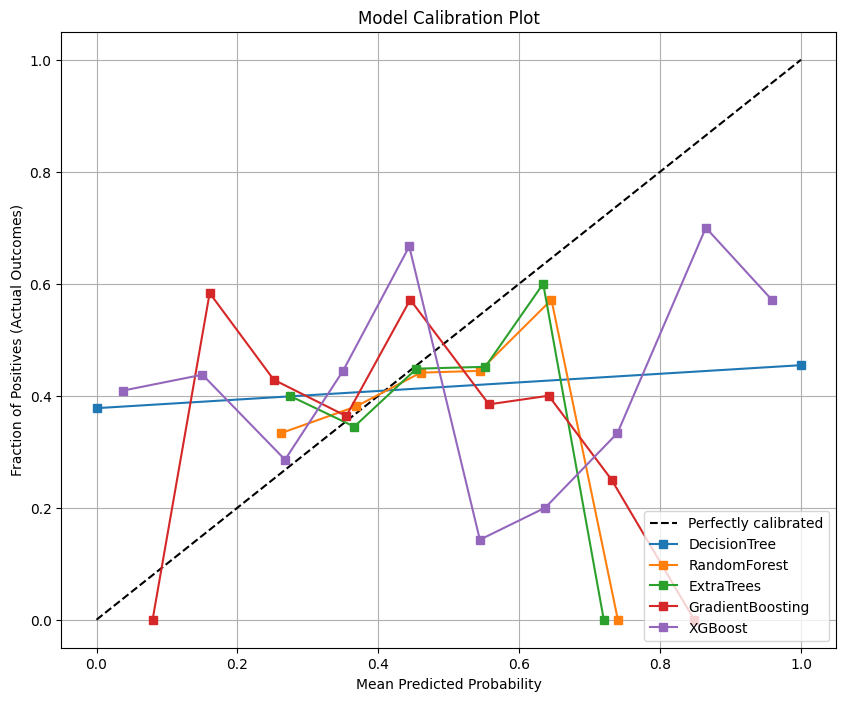

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# --- Assumed Pre-defined Variables ---
# This code assumes that the following variables are already defined from your previous steps:
# X_train, y_train, X_test, y_test, and feature_names
# For a runnable example, we will use dummy data here:
X_train, X_test, y_train, y_test = train_test_split(np.random.rand(500, 10), np.random.randint(0, 2, 500), test_size=0.2, random_state=42)

# --- Your Models Dictionary ---
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# --- Step 1: Create the Calibration Plot ---
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the ideal, perfectly calibrated line
ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

# Loop through each model to generate and plot its calibration curve
for name, model in models.items():
    # Fit the model on the full training data
    model.fit(X_train, y_train)

    # Get predicted probabilities on the test data
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba (e.g., some SVMs), this might be needed
        y_prob = model.decision_function(X_test)

    # Use scikit-learn's calibration_curve to get the plot data
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)

    # Plot the model's calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

# --- Step 2: Add Labels, Title, and Legend ---
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives (Actual Outcomes)")
ax.set_title("Model Calibration Plot")
ax.legend(loc="lower right")
plt.grid(True)

# Save the plot as an image
plt.savefig("all_models_calibration_plot.png")

# Display the plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier # This requires 'xgboost' to be installed

# --- Assumed Pre-defined Variables ---
# This code assumes that the following variables are already defined:
# X_train, y_train, X_test, y_test
# For a runnable example, we will use dummy data here:
np.random.seed(42)
X_train = pd.DataFrame(np.random.rand(500, 10))
y_train = pd.Series(np.random.randint(0, 2, 500))
X_test = pd.DataFrame(np.random.rand(200, 10))
y_test = pd.Series(np.random.randint(0, 2, 200))

# Define the models
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# --- Step 1: Generate bootstrapped samples from the training data ---
bootstrapped_samples = []
n_bootstraps = 10
for b in range(n_bootstraps):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + b)
    bootstrapped_samples.append((X_boot, y_boot))

# --- Step 2: Perform Performance Stability Analysis ---
boot_metrics = {name: [] for name in models}
for X_boot, y_boot in bootstrapped_samples:
    for name, model in models.items():
        model.fit(X_boot, y_boot)
        y_pred = model.predict(X_test)
        boot_metrics[name].append({
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        })

# --- Step 3: Compute Mean, Std, and 95% CI ---
summary = []
for name in boot_metrics:
    accs = [m["accuracy"] for m in boot_metrics[name]]
    precs = [m["precision"] for m in boot_metrics[name]]
    recalls = [m["recall"] for m in boot_metrics[name]]
    f1s = [m["f1"] for m in boot_metrics[name]]

    # Calculate statistics
    acc_mean, acc_std = np.mean(accs), np.std(accs)
    prec_mean, prec_std = np.mean(precs), np.std(precs)
    rec_mean, rec_std = np.mean(recalls), np.std(recalls)
    f1_mean, f1_std = np.mean(f1s), np.std(f1s)

    # Compute 95% Confidence Intervals
    acc_ci = 1.96 * acc_std
    prec_ci = 1.96 * prec_std
    rec_ci = 1.96 * rec_std
    f1_ci = 1.96 * f1_std

    summary.append({
        "Model": name,
        "Accuracy_Mean_Std": f"{acc_mean:.3f} ± {acc_std:.3f}",
        "Accuracy_95%CI": f"({acc_mean - acc_ci:.3f}, {acc_mean + acc_ci:.3f})",
        "Precision_Mean_Std": f"{prec_mean:.3f} ± {prec_std:.3f}",
        "Precision_95%CI": f"({prec_mean - prec_ci:.3f}, {prec_mean + prec_ci:.3f})",
        "Recall_Mean_Std": f"{rec_mean:.3f} ± {rec_std:.3f}",
        "Recall_95%CI": f"({rec_mean - rec_ci:.3f}, {rec_mean + rec_ci:.3f})",
        "F1_Mean_Std": f"{f1_mean:.3f} ± {f1_std:.3f}",
        "F1_95%CI": f"({f1_mean - f1_ci:.3f}, {f1_mean + f1_ci:.3f})"
    })

df_summary = pd.DataFrame(summary)
print("\n--- Model Performance with Mean, Std, and 95% CI ---")
print(df_summary.set_index('Model').to_string())


--- Model Performance with Mean, Std, and 95% CI ---
                 Accuracy_Mean_Std  Accuracy_95%CI Precision_Mean_Std Precision_95%CI Recall_Mean_Std    Recall_95%CI    F1_Mean_Std        F1_95%CI
Model                                                                                                                                               
DecisionTree         0.512 ± 0.029  (0.455, 0.570)      0.503 ± 0.028  (0.448, 0.559)   0.541 ± 0.037  (0.469, 0.612)  0.521 ± 0.026  (0.470, 0.572)
RandomForest         0.495 ± 0.042  (0.412, 0.577)      0.486 ± 0.036  (0.416, 0.557)   0.550 ± 0.067  (0.418, 0.682)  0.515 ± 0.044  (0.429, 0.601)
ExtraTrees           0.509 ± 0.033  (0.444, 0.575)      0.499 ± 0.030  (0.440, 0.559)   0.591 ± 0.067  (0.460, 0.721)  0.540 ± 0.040  (0.462, 0.618)
GradientBoosting     0.508 ± 0.031  (0.448, 0.568)      0.498 ± 0.030  (0.440, 0.556)   0.522 ± 0.064  (0.398, 0.647)  0.509 ± 0.039  (0.432, 0.585)
XGBoost              0.505 ± 0.027  (0.453, 0.557)  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# --- Assumed Pre-defined Variables ---
# This code assumes that the following variables are already defined:
# X_train, y_train, X_test, y_test
# For a runnable example, we will use dummy data here:
np.random.seed(42)
X_train = pd.DataFrame(np.random.rand(500, 10))
y_train = pd.Series(np.random.randint(0, 2, 500))
X_test = pd.DataFrame(np.random.rand(200, 10))
y_test = pd.Series(np.random.randint(0, 2, 200))

# Define the models
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# --- Step 1: Generate bootstrapped samples from the training data ---
bootstrapped_samples = []
n_bootstraps = 500
for b in range(n_bootstraps):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + b)
    bootstrapped_samples.append((X_boot, y_boot))

# --- Step 2: Perform Performance Stability Analysis ---
boot_metrics = {name: [] for name in models}
for X_boot, y_boot in bootstrapped_samples:
    for name, model in models.items():
        model.fit(X_boot, y_boot)
        y_pred = model.predict(X_test)
        boot_metrics[name].append({
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        })

# --- Step 3: Compute Mean, Std, and CV ---
summary = []
for name in boot_metrics:
    accs = [m["accuracy"] for m in boot_metrics[name]]
    precs = [m["precision"] for m in boot_metrics[name]]
    recalls = [m["recall"] for m in boot_metrics[name]]
    f1s = [m["f1"] for m in boot_metrics[name]]

    # Calculate statistics
    acc_mean, acc_std = np.mean(accs), np.std(accs)
    prec_mean, prec_std = np.mean(precs), np.std(precs)
    rec_mean, rec_std = np.mean(recalls), np.std(recalls)
    f1_mean, f1_std = np.mean(f1s), np.std(f1s)

    # Compute Coefficient of Variation (CV)
    acc_cv = (acc_std / acc_mean) if acc_mean > 0 else 0
    prec_cv = (prec_std / prec_mean) if prec_mean > 0 else 0
    rec_cv = (rec_std / rec_mean) if rec_mean > 0 else 0
    f1_cv = (f1_std / f1_mean) if f1_mean > 0 else 0

    summary.append({
        "Model": name,
        "Accuracy_Mean": f"{acc_mean:.3f}",
        "Accuracy_Std": f"{acc_std:.3f}",
        "Accuracy_CV": f"{acc_cv:.3f}",
        "Precision_Mean": f"{prec_mean:.3f}",
        "Precision_Std": f"{prec_std:.3f}",
        "Precision_CV": f"{prec_cv:.3f}",
        "Recall_Mean": f"{rec_mean:.3f}",
        "Recall_Std": f"{rec_std:.3f}",
        "Recall_CV": f"{rec_cv:.3f}",
        "F1_Mean": f"{f1_mean:.3f}",
        "F1_Std": f"{f1_std:.3f}",
        "F1_CV": f"{f1_cv:.3f}"
    })

df_summary = pd.DataFrame(summary)
print("\n--- Model Performance with CV ---")
print(df_summary.set_index('Model').to_string())


--- Model Performance with CV ---
                 Accuracy_Mean Accuracy_Std Accuracy_CV Precision_Mean Precision_Std Precision_CV Recall_Mean Recall_Std Recall_CV F1_Mean F1_Std  F1_CV
Model                                                                                                                                                   
DecisionTree             0.501        0.034       0.069          0.491         0.033        0.067       0.534      0.060     0.113   0.511  0.042  0.081
RandomForest             0.496        0.029       0.058          0.487         0.026        0.052       0.580      0.072     0.124   0.528  0.040  0.076
ExtraTrees               0.503        0.029       0.057          0.494         0.025        0.051       0.594      0.076     0.128   0.538  0.040  0.075
GradientBoosting         0.499        0.030       0.059          0.490         0.027        0.056       0.555      0.068     0.122   0.519  0.039  0.076
XGBoost                  0.497        0.030    